In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/disk-compression-diffusion/dynamics_0/'
data = dp.data.load(p, location=['final', 'init'])

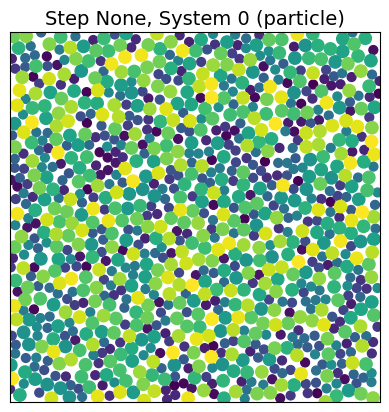

In [3]:
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', None)

In [398]:
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from numba import njit
from tqdm import tqdm
import numpy as np

@njit(cache=True, fastmath=True)
def compute_forces_numba(pos, rad, k, neighbors_i, neighbors_j, box_size):
    force = np.zeros_like(pos, dtype=pos.dtype)
    virial_stress = np.zeros((pos.shape[0], 4), dtype=pos.dtype)
    pe = np.zeros(pos.shape[0], dtype=pos.dtype)
    for i, j in zip(neighbors_i, neighbors_j):
        dx = pos[i, 0] - pos[j, 0]
        dy = pos[i, 1] - pos[j, 1]
        dx -= box_size[0] * np.round(dx / box_size[0])
        dy -= box_size[1] * np.round(dy / box_size[1])
        rij = np.sqrt(dx ** 2 + dy ** 2)
        sij = rad[i] + rad[j]
        overlap = sij - rij

        if overlap > 0.0:
            mag = k * overlap
            fx = mag * dx / rij
            fy = mag * dy / rij

            force[i, 0] += fx
            force[i, 1] += fy
            force[j, 0] -= fx
            force[j, 1] -= fy

            virial_stress[i, 0] += 0.5 * fx * dx
            virial_stress[i, 1] += 0.5 * fx * dy
            virial_stress[i, 2] += 0.5 * fy * dx
            virial_stress[i, 3] += 0.5 * fy * dy
            virial_stress[j, 0] += 0.5 * fx * dx
            virial_stress[j, 1] += 0.5 * fx * dy
            virial_stress[j, 2] += 0.5 * fy * dx
            virial_stress[j, 3] += 0.5 * fy * dy

            e_pair = 0.5 * k * overlap * overlap
            pe[i] += 0.5 * e_pair
            pe[j] += 0.5 * e_pair

    return force, virial_stress, pe


@njit(cache=True, fastmath=True)
def compute_pairwise_force_matrix(pos, rad, k, neighbors_i, neighbors_j, box_size):
    F = np.zeros((pos.shape[0], pos.shape[0], 2))
    R = np.zeros((pos.shape[0], pos.shape[0], 2))
    for i, j in zip(neighbors_i, neighbors_j):
        dx = pos[i, 0] - pos[j, 0]
        dy = pos[i, 1] - pos[j, 1]
        dx -= box_size[0] * np.round(dx / box_size[0])
        dy -= box_size[1] * np.round(dy / box_size[1])
        rij = np.sqrt(dx ** 2 + dy ** 2)
        sij = rad[i] + rad[j]
        overlap = sij - rij

        if overlap > 0.0:
            mag = k * overlap
            fx = mag * dx / rij
            fy = mag * dy / rij

            F[i, j, 0] += fx
            F[i, j, 1] += fy
            F[j, i, 0] -= fx
            F[j, i, 1] -= fy

            R[i, j, 0] = dx
            R[i, j, 1] = dy
            R[j, i, 0] = - dx
            R[j, i, 1] = - dy
    return F, R

def build_neighbor_list(pos, box_size, rmax):
    tree = cKDTree(np.mod(pos, box_size), boxsize=box_size)
    pairs = np.fromiter(tree.query_pairs(r=rmax), dtype=np.dtype([('i',np.int32),('j',np.int32)]))
    return pairs['i'], pairs['j']

def calc_msd(x, y, t):
    results = np.zeros(len(t) - 1)
    windows = np.zeros_like(results)
    for i in range(1, len(t)):
        results[i - 1] = np.sum((x[i:] - x[:-i]) ** 2 + (y[i:] - y[:-i]) ** 2) / (x[i:].size)
        windows[i - 1] = i
    return results, windows

def calc_acf(Y, t):
    shape = [len(t) - 1]
    windows = np.zeros(shape)
    shape.extend(list(Y[0].shape))
    results = np.zeros(shape)
    for i in tqdm(range(1, len(t))):
        results[i - 1] = np.sum(Y[i:] * Y[:-i], axis=0) / (t[i:].size)
        windows[i - 1] = i
    return results, windows

In [128]:
k = 1
radii = data.rad.copy()
pos = data.pos.copy()
vel = data.vel.copy()
box_size = data.box_size[0].copy()
mass = data.mass.copy()



delta_phi = 0.01
phi = np.sum(np.pi * radii ** 2) / np.prod(box_size)
new_box_size = np.sqrt(np.sum(np.pi * radii ** 2) / (phi + delta_phi)) * np.ones_like(box_size)
scale = new_box_size / box_size
box_size *= scale
pos *= scale

In [399]:
N_steps = 100000
N_save_steps = 1000
dt = 1e-2
temp_target = 1e-4
use_nvt = False

verlet_skin = 0.5
verlet_cutoff = 2 * np.max(data.rad) * (1 + verlet_skin)
displacement = np.zeros_like(data.rad)


neighbors_i, neighbors_j = build_neighbor_list(pos, box_size, verlet_cutoff)
force, virial_stress, pe = compute_forces_numba(pos, radii, k, neighbors_i, neighbors_j, box_size)
disp = np.zeros_like(radii)
last_pos = pos.copy()

pe_total = np.zeros(N_save_steps)
ke_total = np.zeros(N_save_steps)
K_total = np.zeros((N_save_steps, 2, 2))
W_total = np.zeros((N_save_steps, 2, 2))
t = np.zeros_like(pe_total)
F = []
R = []

for i in range(N_steps):
    # update state
    vel += force * dt / (2 * mass[:, None])
    pos += vel * dt
    force, virial_stress, pe = compute_forces_numba(pos, radii, k, neighbors_i, neighbors_j, box_size)
    vel += force * dt / (2 * mass[:, None])

    # update displacements and neighbors if needed
    disp = np.linalg.norm(pos - last_pos, axis=1)
    if np.any(disp > verlet_skin / 2.0):
        neighbors_i, neighbors_j = build_neighbor_list(pos, box_size, verlet_cutoff)
        last_pos = pos.copy()

    # log
    if i % N_steps // N_save_steps == 0:
        t[i] = dt * i
        pe_total[i] = np.sum(pe)
        ke_total[i] = 0.5 * np.sum(mass[:, None] * vel ** 2)

        kinetic_stress = np.zeros_like(virial_stress)
        kinetic_stress[:, 0] = mass * vel[:, 0] ** 2
        kinetic_stress[:, 2] = mass * vel[:, 1] * vel[:, 0]
        kinetic_stress[:, 1] = mass * vel[:, 0] * vel[:, 1]
        kinetic_stress[:, 3] = mass * vel[:, 1] ** 2
        W_total[i] = virial_stress.sum(axis=0).reshape(2, 2)
        K_total[i] = kinetic_stress.sum(axis=0).reshape(2, 2)
        # sigma = -(K + W) / np.prod(box_size)
        _F, _R = compute_pairwise_force_matrix(pos, radii, k, neighbors_i, neighbors_j, box_size)
        F.append(_F)
        R.append(_R)

    if use_nvt and i % 100 == 0:
        ke = 0.5 * np.sum(mass[:, None] * vel ** 2)
        vel *= np.sqrt(temp_target * pos.shape[0] / ke)

In [400]:
R[0]
F[0]

f0 = np.array(F)

In [352]:
# W_acf, lags = calc_acf(W_total, t)
# K_acf, lags = calc_acf(K_total, t)
S_acf, lags = calc_acf((W_total + K_total) / np.prod(box_size), t)

100%|██████████| 9999/9999 [00:00<00:00, 32677.44it/s]


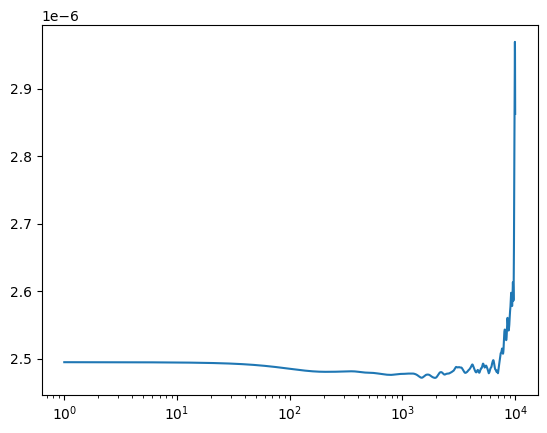

In [353]:
plt.plot(lags, (S_acf[:, 0, 0] + S_acf[:, 1, 1]) / 2)
plt.xscale('log')

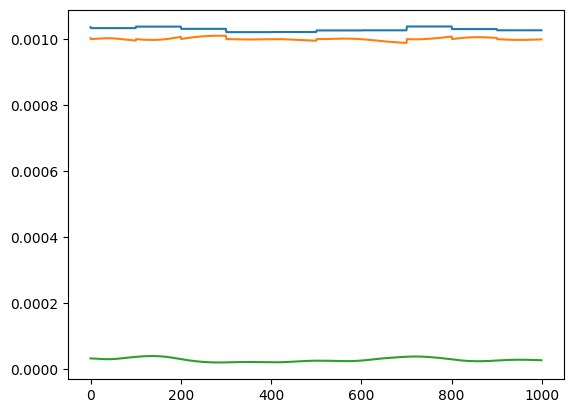

In [331]:
plt.plot(pe_total + ke_total)
plt.plot(ke_total)
plt.plot(pe_total)